# Exact residues using reduced spectral integrand.

We have the reduced form of the spectral integrand and have checked it.  This should allow us to compute the exact residues.  Here we do that and check that we get the same as we expect.

Currently we did the contour integral via quadrature of the spectral integrand and got a stable number, but the exact residue formula is reproducing it yet.  Need to debug within that latter formula

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from slab import SlabExact, plot_complex, plot_complex_surface
plt.style.use('dark_background')
%matplotlib widget

In [2]:
A = SlabExact(scale=1e-5, Ts=[6.5, 1, 8, 2.5, 6.5],
      ns=[1, 1.44, 1, 1.44, 1], xrefs=[100, 40, 300, 40, 100],
      symmetric=True, wl=6.9e-6, Shift=0)

In [3]:
def Spectral_Integrand(C, x=0, s=0):
    try:
        len(C)
        C = np.asanyarray(C)
    except TypeError:
        C = np.asanyarray([C])

    x_idx, s_idx = A.region_index(x), A.region_index(s)
    
    Tx = A.transmission_matrix(C, up_to_region=x_idx)
    Ts = A.transmission_matrix(C, up_to_region=s_idx)
    M = A.transmission_matrix(C)
    
    a, b, c, d = M[...,0,0], M[...,0,1], M[...,1,0], M[...,1,1]
    
    Zx, Zs = A.Zi_from_Z0(C, ni=A.ns[x_idx]), A.Zi_from_Z0(C, ni=A.ns[s_idx])
    
    ex = np.zeros(Zx.shape + (1, 2), dtype=complex)
    es = np.zeros(Zx.shape + (1, 2), dtype=complex)
    
    ex[..., 0, 0] = np.exp(1j * Zx * x)
    ex[..., 0, 1] = np.exp(-1j * Zx * x)
    
    es[..., 0, 0] = np.exp(1j * Zs * s)
    es[..., 0, 1] = np.exp(-1j * Zs * s)
    
    Ex = ex @ Tx
    Es = es @ Ts

    E, F = Ex[..., 0,0], Ex[..., 0,1]
    G, H = Es[..., 0,0], Es[..., 0,1]
    num = 2 * (E * G * b * d - E * H * a * d - F * G * a * d + F * H * a * c)
    return (1 / np.pi) * num / (- 4 * a * d)

In [4]:
Eig = A.normalizer('eigvec')

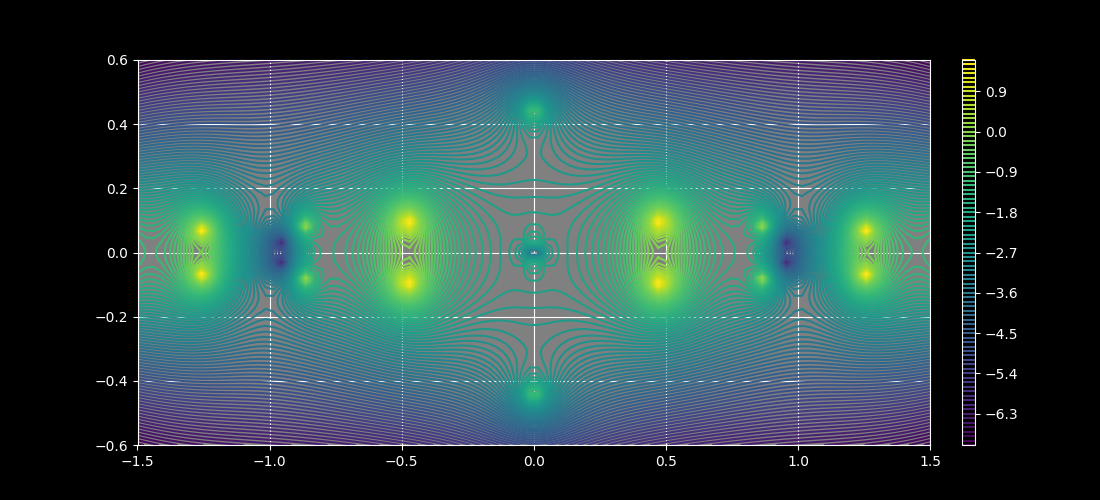

In [5]:
plot_complex(Spectral_Integrand, -1.5, 1.5, -.6, .6, iref=100, rref=100, levels=100)

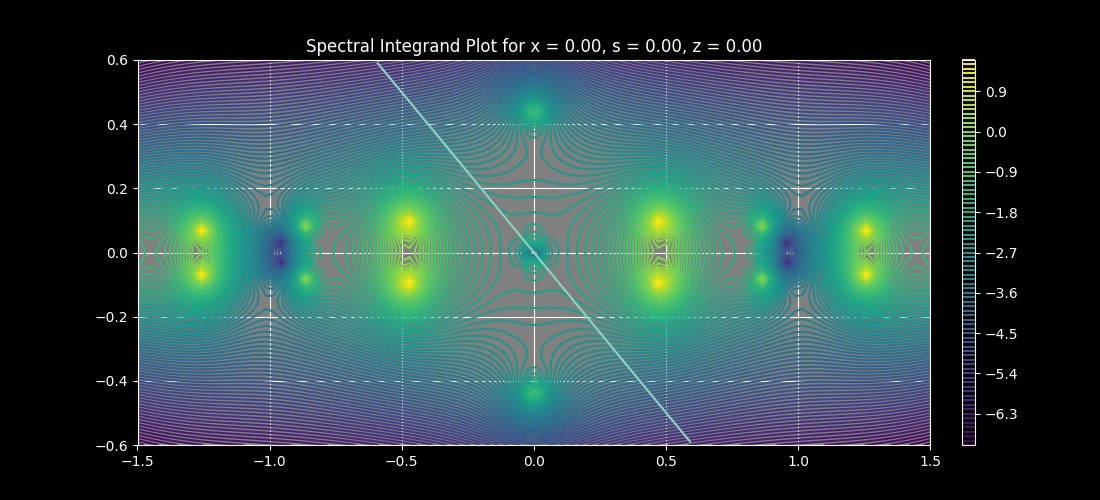

In [6]:
A.spectral_integrand_plot(-1.5, 1.5, -.6, .6, s=0, Normalizer=Eig)

In [7]:
# plot_complex_surface(lambda C: Spectral_Integrand(C) / A.spectral_integrand(C, s=0, Normalizer=Eig), -1.5, 1.5, -.6, .6, iref=200, rref=200)

Okay, the above just shows that we have the spectral integrand right in reduced form.  What are the residues?  Let's find a pole:

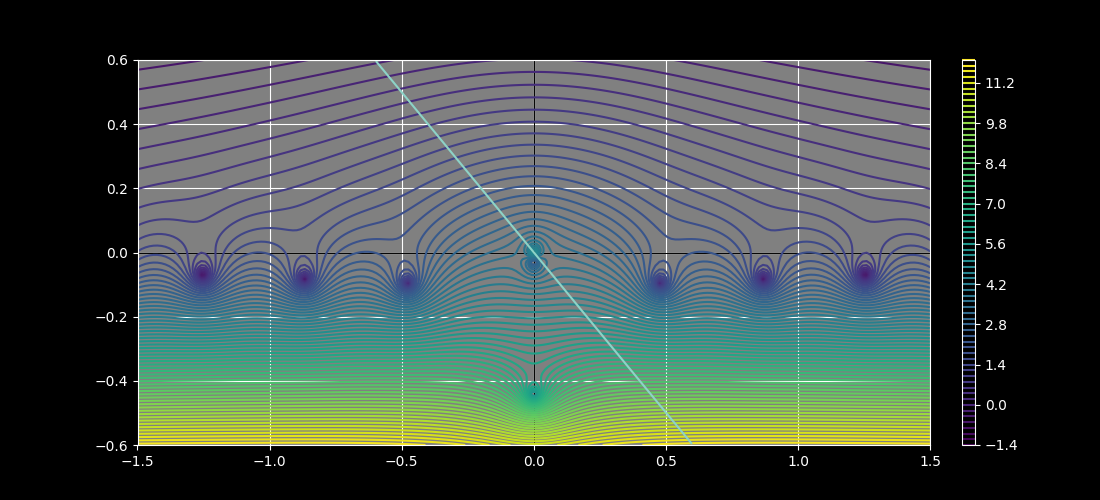

In [8]:
A.determinant_plot(-1.5, 1.5, -.6, .6, mode_type='guided', Normalizer=Eig);

In [9]:
Z = newton(A.determinant, np.array(.5-.1j))
A.plot_points(Z)

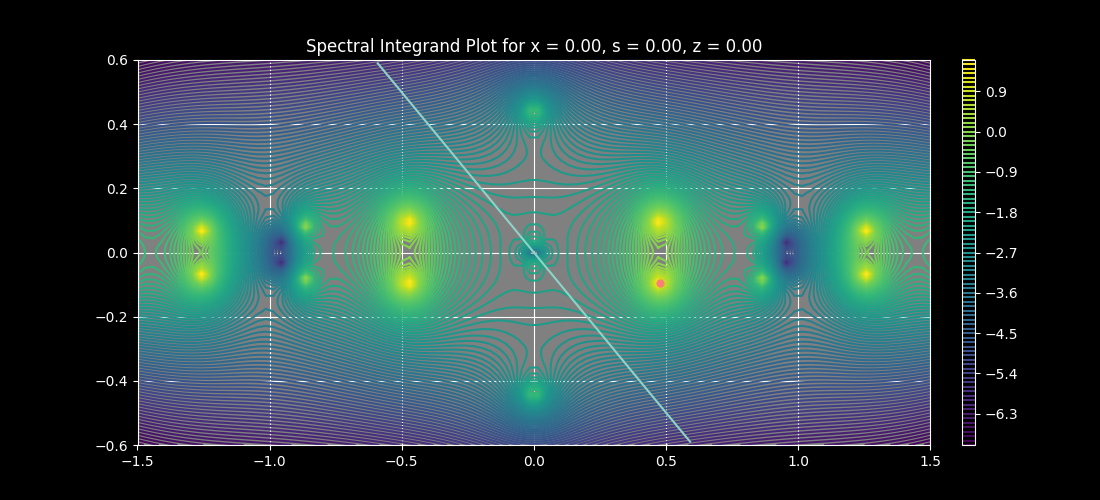

In [10]:
A.spectral_integrand_plot(-1.5, 1.5, -.6, .6, s=0, Normalizer=Eig)
A.plot_points(Z, c='C3')

Okay, let's compute the residue around it by hand:

In [11]:
contour = A.circular_contour(Z, .01, 30)
Cs, Ss, dCdS = contour['Cs'], contour['Ss'], contour['dCdS']
Nz = len(Cs)
dS = Ss[1:] - Ss[:-1]

integral_via_quadrature = sum([Spectral_Integrand(Cs[i]) * dCdS[i] * dS[i] for i in range(Nz-1)])
integral_via_quadrature

array([-0.27953508-0.0034076j])

Now we should be able to get exactly this (or rather this times 2 $\pi i$), by using $h(Z)/g'(Z)$ for the appropriate $h$ and $g$. For this pole, the part of the denominator that goes to zero is component $d = M_{1,1}$ while $a=M_{0,0}$ is non-zero.  So we include $d$ with the numerator (along with the $-4$) and keep $a$ below.  We need to find $a'(Z)$, which we have already implemented and checked:

In [12]:
def numerator(C, x=0, s=0):
    try:
        len(C)
        C = np.asanyarray(C)
    except TypeError:
        C = np.asanyarray([C])

    x_idx, s_idx = A.region_index(x), A.region_index(s)
    
    Tx = A.transmission_matrix(C, up_to_region=x_idx)
    Ts = A.transmission_matrix(C, up_to_region=s_idx)
    M = A.transmission_matrix(C)
    
    a, b, c, d = M[...,0,0], M[...,0,1], M[...,1,0], M[...,1,1]
    
    Zx, Zs = A.Zi_from_Z0(C, ni=A.ns[x_idx]), A.Zi_from_Z0(C, ni=A.ns[s_idx])
    
    ex = np.zeros(Zx.shape + (1, 2), dtype=complex)
    es = np.zeros(Zx.shape + (1, 2), dtype=complex)
    
    ex[..., 0, 0] = np.exp(1j * Zx * x)
    ex[..., 0, 1] = np.exp(-1j * Zx * x)
    
    es[..., 0, 0] = np.exp(1j * Zs * s)
    es[..., 0, 1] = np.exp(-1j * Zs * s)
    
    Ex = ex @ Tx
    Es = es @ Ts

    E, F = Ex[..., 0,0], Ex[..., 0,1]
    G, H = Es[..., 0,0], Es[..., 0,1]
    num = 2 * (E * G * b * d + F * H * a * c - (E * H + F * G) * a * d)
    return 1 / np.pi * num

def denominator(C, x=0, s=0):
    Mprime = A.transmission_matrix(C, derivate=True)
    M = A.transmission_matrix(C)
    return - 4 * (Mprime[..., 0, 0] * M[..., 1, 1] + M[..., 0, 0] * Mprime[..., 1, 1])

def residue(C, x=0, s=0):
    return numerator(C, x=x, s=s) / denominator(C, x=x, s=s)

In [13]:
integral_via_exact_residue = 2 * np.pi * 1j * residue(Z)
integral_via_exact_residue, integral_via_quadrature

(array([-0.27953508-0.0034076j]), array([-0.27953508-0.0034076j]))

Okay they're the same now after some playing around.  We just weren't keeping track well of what was in the numerator and denominator.  This may be causing an issue when going to the modes.  The residue should be given by a leaky mode $u_\ell(Z_0)$ where $Z_0$ is a pole location when $ d = M_{1,1} = 0$.  Below we show the even further reduced residue in this case:

In [14]:
def numerator_at_d_equals_zero(C, x=0, s=0):
    try:
        len(C)
        C = np.asanyarray(C)
    except TypeError:
        C = np.asanyarray([C])

    x_idx, s_idx = A.region_index(x), A.region_index(s)
    
    Tx = A.transmission_matrix(C, up_to_region=x_idx)
    Ts = A.transmission_matrix(C, up_to_region=s_idx)
    M = A.transmission_matrix(C)
    
    a, b, c, d = M[...,0,0], M[...,0,1], M[...,1,0], M[...,1,1]
    
    Zx, Zs = A.Zi_from_Z0(C, ni=A.ns[x_idx]), A.Zi_from_Z0(C, ni=A.ns[s_idx])
    
    ex = np.zeros(Zx.shape + (1, 2), dtype=complex)
    es = np.zeros(Zx.shape + (1, 2), dtype=complex)
    
    ex[..., 0, 0] = np.exp(1j * Zx * x)
    ex[..., 0, 1] = np.exp(-1j * Zx * x)
    
    es[..., 0, 0] = np.exp(1j * Zs * s)
    es[..., 0, 1] = np.exp(-1j * Zs * s)
    
    Ex = ex @ Tx
    Es = es @ Ts

    E, F = Ex[..., 0,0], Ex[..., 0,1]
    G, H = Es[..., 0,0], Es[..., 0,1]
    num = 2 * (F * H * c)
    return 1 / np.pi * num

def denominator_at_d_equals_zero(C, x=0, s=0):
    dp = A.transmission_matrix(C, derivate=True)[...,1, 1]
    # a = A.transmission_matrix(C)[..., 0, 0]
    return - 4 * (dp)

def residue_at_d_equals_zero(C, x=0, s=0):
    return numerator_at_d_equals_zero(C, x=x, s=s) / denominator_at_d_equals_zero(C, x=x, s=s)

In [15]:
residue_at_d_equals_zero(Z), residue(Z)

(array([-0.00054234+0.04448939j]), array([-0.00054234+0.04448939j]))

Even the $a$ term cancels, so it really is just

$$ \frac{-1}{2 \pi} \frac{F H c}{d'}.$$

But this is really just like having the product of a mode $u_\ell(x,Z_0)$ with itself evaluated at $s$:

$$  \frac{-1}{2 \pi} \frac{F H c}{d'} = u_\ell(x,Z_0)\, u_\ell(x,Z_0) =  (e_x T_j v)(v^T T^T_k e_s^T)$$

where $v = (0, \sqrt{\frac{-c}{2 \pi d'}}).$  We implemented these modes already as the default behavior of finding modes:

In [16]:
F = A.fields(Z, rounding=11)
F(0) * F(0)

array([-0.00054234+0.04448939j])

But there is a problem with this.  So let's debug within this:

In [18]:
M = A.transmission_matrix(Z, derivate=True)  # ERROR!!! Bug is here.

M_prime = A.transmission_matrix(Z, derivate=True)

d_prime, c = M_prime[..., 1, 1], M[..., 1, 0]

np.array([0, np.sqrt(-c/(2 * np.pi * d_prime))[0]])

array([0.        +0.j        , 0.05482039+0.35554297j])

Oh dang I found it right away: I was derivating both matrices when I only wanted to derivate one.  Let's go back to the normalized leaky (and guided) modes notebook and see if it works in general now.